In [54]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.lines import Line2D
from scipy.linalg import block_diag

sys.path.append(os.path.abspath(os.path.join('../../src')))
sys.path.append(os.path.abspath(os.path.join('../newton_based_algorithms')))

from utils import get_form_initial_conditions
try:
    from tudatpy.astro.time_conversion import DateTime
    use_tudatpy = True
except ImportError:
    print('No tudatpy available')
    use_tudatpy = False
from dynamics import SatelliteDynamics, Propagator

from unkkt import UNKKT
from tree_newton import Tree_Newton
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

try:
    from concurrent.futures import ProcessPoolExecutor
    use_several_cpus = True
except ImportError:
    print('No concurrent.futures.ProcessPoolExecutor available')
    use_several_cpus = False
use_several_cpus = True

use_causal = False

No tudatpy available


In [55]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [56]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 100  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
if use_tudatpy:
    simulation_start_epoch = DateTime(2000, 1, 1).epoch()
    simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [57]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
if use_tudatpy:
    propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
    X_true = propagator.run().T.reshape(24, 1, T)
else:
    X_true = np.zeros((24, 1, T))
    X_true[:, :, 0] = X_initial
    for t in range(T - 1):
        X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

In [58]:
if use_tudatpy:
    # Estimate process noise
    X_our_model = np.zeros((24, 1, T))
    X_our_model[:, :, 0] = X_initial
    for t in range(T - 1):
        X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

    # Compute the difference between the ground truth and the model after initial conditions
    diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
    diff_flattened = diff.T.reshape(-1, 24)

    # Calculate the general covariance matrix of the flattened differences
    Q = np.cov(diff_flattened, rowvar=False)

    # Create a zero matrix of the same shape
    Q_modified = np.zeros_like(Q)

    # Fill only the required block diagonals
    Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
    Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
    Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
    Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
    Q = Q_modified
    pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

In [59]:
# propagator2 = Propagator(simulation_start_epoch, simulation_end_epoch, 1.0, X_initial)
# X_true2 = propagator2.run().T.reshape(24, 1, 23641)

# # Estimate process noise
# X_our_model2 = np.zeros((24, 1, 23641))
# X_our_model2[:, :, 0] = X_initial
# for t in range(23641 - 1):
#     X_our_model2[:, :, t + 1] = SatelliteDynamics().x_new(1.0, X_true2[:, :, t])

# # Compute the difference between the ground truth and the model after initial conditions
# diff2 = X_true2[:, :, 1:] - X_our_model2[:, :, 1:]
# diff_flattened2 = diff2.T.reshape(-1, 24)

# # Calculate the general covariance matrix of the flattened differences
# Q2 = np.cov(diff_flattened2, rowvar=False)

# # Create a zero matrix of the same shape
# Q_modified2 = np.zeros_like(Q2)

# # Fill only the required block diagonals
# Q_modified2[:6, :6] = np.diag(np.diag(Q2[:6, :6]))
# Q_modified2[6:12, 6:12] = np.diag(np.diag(Q2[6:12, 6:12]))
# Q_modified2[12:18, 12:18] = np.diag(np.diag(Q2[12:18, 12:18]))
# Q_modified2[18:, 18:] = np.diag(np.diag(Q2[18:, 18:]))
# Q2 = Q_modified2
# pd.DataFrame(Q2[:6, :6]), pd.DataFrame(Q2[6:12, 6:12]), pd.DataFrame(Q2[12:18, 12:18]), pd.DataFrame(Q2[18:, 18:])

In [60]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [61]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
# unkkt.grad_tol = tol
# unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
# tree_newton.grad_tol = tol
# tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
# approxh_newton.grad_tol = tol
# approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
# mm_newton.grad_tol = tol
# mm_newton.max_iter = max_iter
# mm_newton.mm_tol = tol
# mm_newton.mm_max_iter = 1

In [62]:
# Simulation setup
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [63]:
if use_several_cpus and use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = X_est  # Centralized Newton
    X_est_tree_newton_history = X_est  # Tree Newton
    X_est_approx_newton_history = X_est  # ApproxH Newton
    X_est_mm_history = X_est  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n - W + 1] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_est[:, :, W - 1]
        X_est_tree_newton = X_est[:, :, W - 1]
        X_est_approx_newton = X_est[:, :, W - 1]
        X_est_mm = X_est[:, :, W - 1]
    
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=3) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
            
            # Propagate the estimated initial conditions until the end of the finite-horizon window
            for i in range(W):
                X_est_unkkt_history[:, :, n] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, n])
                X_est_tree_newton_history[:, :, n] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, n])
                X_est_approx_newton_history[:, :, n] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, n])
                X_est_mm_history[:, :, n] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, n])
    
            # Plot results **in the main process**
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))
    
            # Cost function values
            ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
            ax1.plot(cost_tree, '.-', label='Tree Newton')
            ax1.plot(cost_approx, '.-', label='ApproxH Newton')
            ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
            ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()
    
            # Gradient norm values
            ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
            ax2.plot(grad_tree, '.-', label='Tree Newton')
            ax2.plot(grad_approx, '.-', label='ApproxH Newton')
            ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()
    
            fig.suptitle(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

Windows:   0%|          | 0/1 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 27667951.86417096
Gradient norm: 757191514.5324916
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
L_norm = 27667951.86417096
Grad_L_norm = 758955877.6398968

Before applying the algorithm
Cost function: 27667951.86417096
Gradient norm: 758955877.6398968
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1
Cost function: 97386.24293793278 (-99.65%)
Gradient norm: 1266489.402469556 (-99.83%)
Global relative error: 580.9204182091999 (46.84%)
Position relative errors: 0.006648666852786237 m, 90.73273348244925 m, 91.92260099645456 m, 566.3

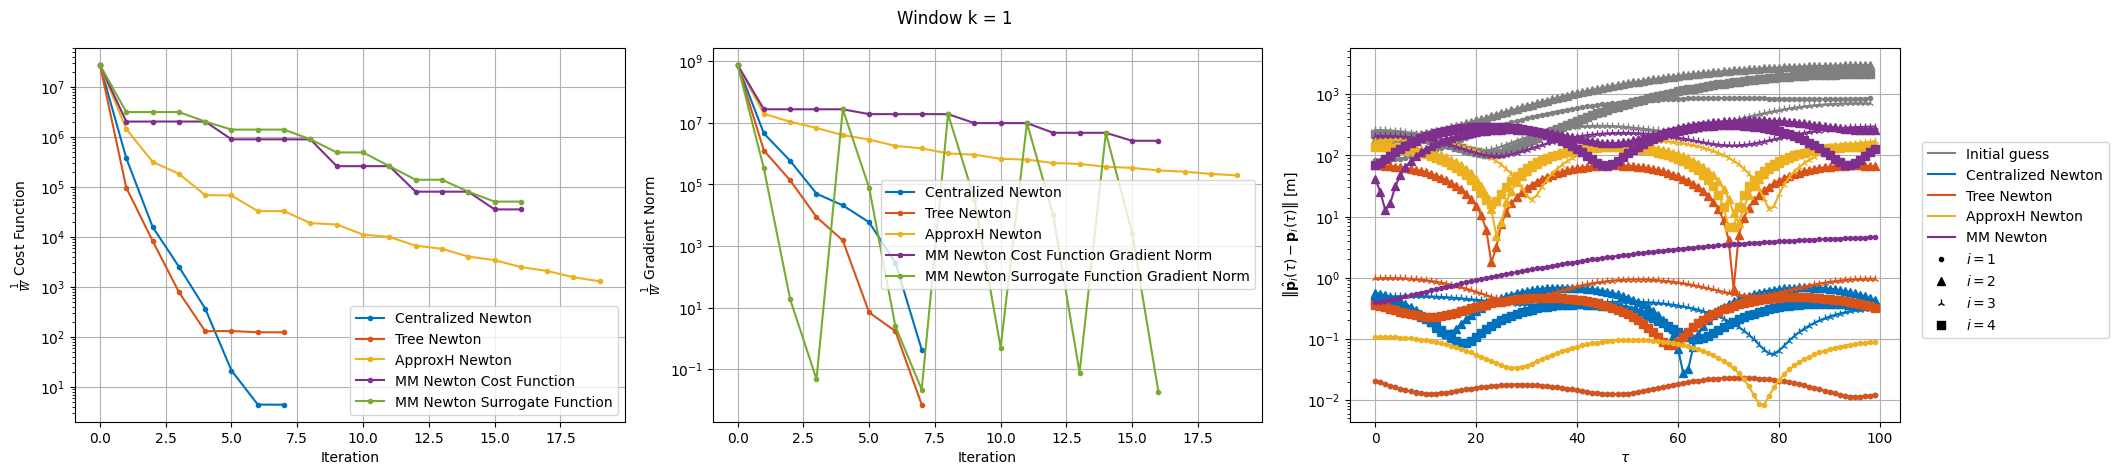


MC runs: 100%|██████████| 1/1 [00:54<00:00, 54.51s/it]


In [64]:
if use_several_cpus and not use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=4) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
    
            # Plot results **in the main process**
            fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))
    
            # Cost function values
            axs[0].plot(cost_unkkt, '.-', label='Centralized Newton')
            axs[0].plot(cost_tree, '.-', label='Tree Newton (original)')
            axs[0].plot(cost_approx, '.-', label='ApproxH Newton')
            axs[0].plot(cost_mm, '.-', label='MM Newton Cost Function')
            axs[0].plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel(r'$\frac{1}{W}$ Cost Function')
            axs[0].set_yscale('log')
            axs[0].grid(True)
            axs[0].legend()
    
            # Gradient norm values
            axs[1].plot(grad_unkkt, '.-', label='Centralized Newton')
            axs[1].plot(grad_tree, '.-', label='Tree Newton')
            axs[1].plot(grad_approx, '.-', label='ApproxH Newton')
            axs[1].plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            axs[1].plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
            axs[1].set_yscale('log')
            axs[1].grid(True)
            axs[1].legend()

            # Initialize storage for current estimates
            X_est_unkkt_current = np.zeros((24, 1, W))
            X_est_tree_newton_current = np.zeros((24, 1, W))
            X_est_approx_newton_current = np.zeros((24, 1, W))
            X_est_mm_current = np.zeros((24, 1, W))
            
            # Simulate forward propagation over the window
            X_est_unkkt_current[:, :, 0] = X_est_unkkt
            X_est_tree_newton_current[:, :, 0] = X_est_tree_newton
            X_est_approx_newton_current[:, :, 0] = X_est_approx_newton
            X_est_mm_current[:, :, 0] = X_est_mm
            
            for tau in range(W - 1):
                X_est_unkkt_current[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_current[:, :, tau])
                X_est_tree_newton_current[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_current[:, :, tau])
                X_est_approx_newton_current[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_current[:, :, tau])
                X_est_mm_current[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_current[:, :, tau])
            
            # Compute position estimation errors
            dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current = position_estimation_error(X_est_unkkt_current, X_true[:, :, n:n + W])
            dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, n:n + W])
            dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current = position_estimation_error(X_est_approx_newton_current, X_true[:, :, n:n + W])
            dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current = position_estimation_error(X_est_mm_current, X_true[:, :, n:n + W])
            
            # Define colors for algorithms
            algorithm_colors = {
                'Initial guess': 'grey',
                'Centralized Newton': 'C0',
                'Tree Newton': 'C1',
                'ApproxH Newton': 'C2',
                'MM Newton': 'C3'
            }
            
            # Define markers for different agents (i = 1, ..., 4)
            markers = ['.', '^', '2', 's', 'P']
            
            # Plot Initial Guess deviations (use the same color for all i)
            for i, dev_initial in enumerate([dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial]):
                axs[2].plot(dev_initial[n:n + W - 1], linestyle='-', color=algorithm_colors['Initial guess'], marker=markers[i])
            
            # Plot Centralized Newton deviations
            for i, dev_unkkt in enumerate([dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current]):
                axs[2].plot(dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
            
            # Plot Tree Newton deviations
            for i, dev_tree in enumerate([dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current]):
                axs[2].plot(dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
            
            # Plot ApproxH Newton deviations
            for i, dev_approxh in enumerate([dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current]):
                axs[2].plot(dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
            
            # Plot MM Newton deviations
            for i, dev_mm in enumerate([dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current]):
                axs[2].plot(dev_mm, linestyle='-', color=algorithm_colors['MM Newton'], marker=markers[i])
            
            # Set axis labels and scale
            axs[2].set_xlabel(r'$\tau$')
            axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
            axs[2].set_yscale('log')
            axs[2].grid(True)
            
            # Create legend (Colors for Algorithms, Markers for Agents)
            legend_elements = [
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial guess'], label='Initial guess'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['MM Newton'], label='MM Newton'),
                Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
                Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
                Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
                Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
            ]
            fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
            fig.suptitle(f'Window k = {n + 1}')
            plt.tight_layout() 
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [65]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False): # n is the index of the end of the finite-horizon window
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n - W + 1 : n + 1])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n - W + 1] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est_unkkt[18:21])} m")
            print("-------- Tree Newton --------")
            X_est_tree_newton = tree_newton.solve_for_each_window(dt, X_est_tree_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(tree_newton.cost_function_values, '.-', label='Tree Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()

            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(tree_newton.grad_norm_values, '.-', label='Tree Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{W}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()

            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            tree_newton.cost_function_values = []
            tree_newton.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

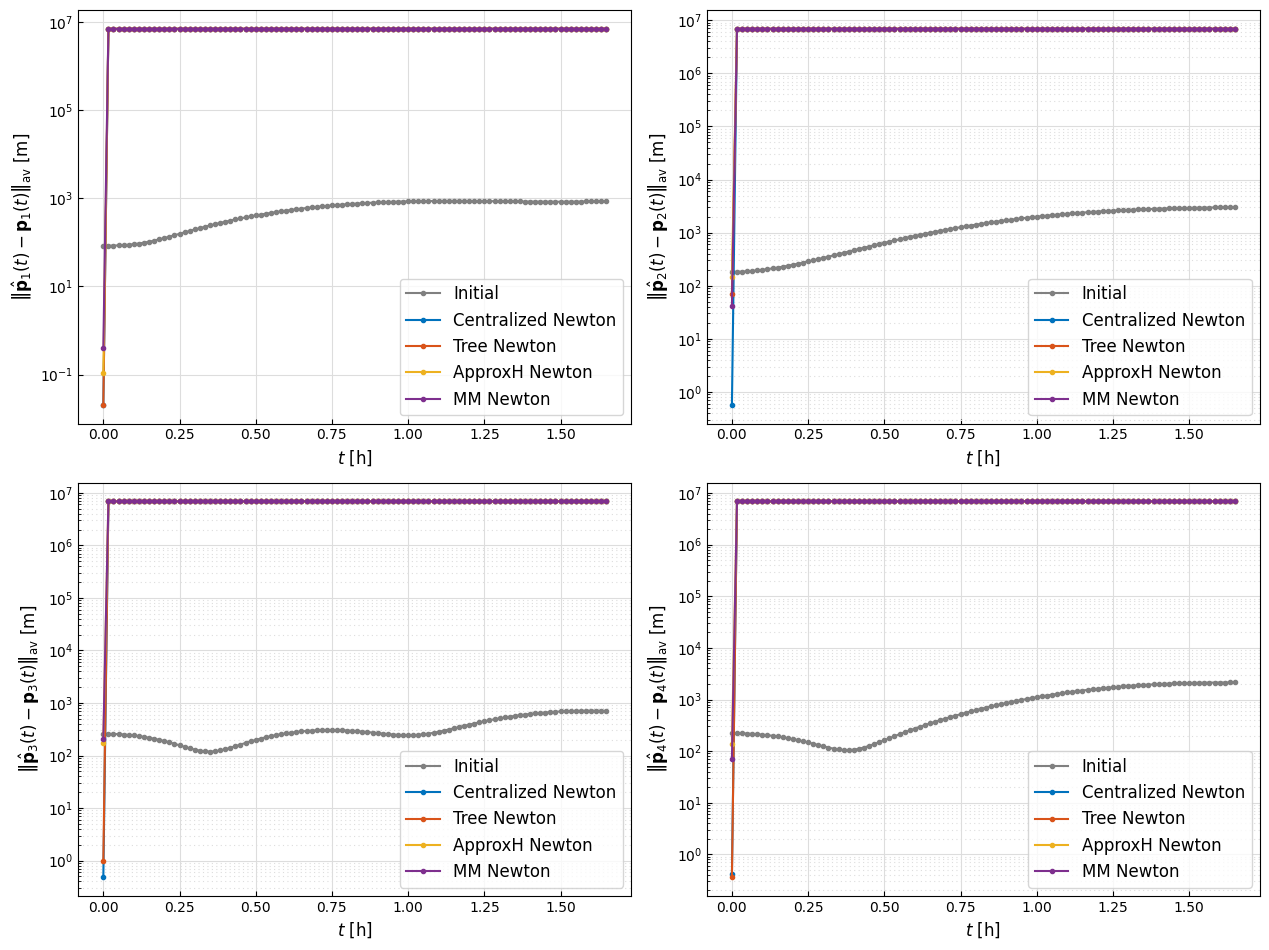

In [66]:
# Extract deviations for Chief and Deputies
dev_chief_unkkt, dev_deputy1_unkkt, dev_deputy2_unkkt, dev_deputy3_unkkt = position_estimation_error(X_est_unkkt_history, X_true)
dev_chief_tree, dev_deputy1_tree, dev_deputy2_tree, dev_deputy3_tree = position_estimation_error(X_est_tree_newton_history, X_true)
dev_chief_approx, dev_deputy1_approx, dev_deputy2_approx, dev_deputy3_approx = position_estimation_error(X_est_approx_newton_history, X_true)
dev_chief_mm, dev_deputy1_mm, dev_deputy2_mm, dev_deputy3_mm = position_estimation_error(X_est_mm_history, X_true)

# Time array
T = X_true.shape[2]

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", color='grey', label="Initial")
axs[0, 0].plot(time, dev_chief_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 0].plot(time, dev_chief_tree, ".-", color='C1', label="Tree Newton")
axs[0, 0].plot(time, dev_chief_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 0].plot(time, dev_chief_mm, ".-", color='C3', label="MM Newton")
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_1(t) - \\mathbf{p}_1(t)\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", color='grey', label="Initial")
axs[0, 1].plot(time, dev_deputy1_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 1].plot(time, dev_deputy1_tree, ".-", color='C1', label="Tree Newton")
axs[0, 1].plot(time, dev_deputy1_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 1].plot(time, dev_deputy1_mm, ".-", color='C3', label="MM Newton")
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_2(t) - \\mathbf{p}_2(t)\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", color='grey', label="Initial")
axs[1, 0].plot(time, dev_deputy2_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 0].plot(time, dev_deputy2_tree, ".-", color='C1', label="Tree Newton")
axs[1, 0].plot(time, dev_deputy2_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 0].plot(time, dev_deputy2_mm, ".-", color='C3', label="MM Newton")
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_3(t) - \\mathbf{p}_3(t)\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", color='grey', label="Initial")
axs[1, 1].plot(time, dev_deputy3_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 1].plot(time, dev_deputy3_tree, ".-", color='C1', label="Tree Newton")
axs[1, 1].plot(time, dev_deputy3_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 1].plot(time, dev_deputy3_mm, ".-", color='C3', label="MM Newton")
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_4(t) - \\mathbf{p}_4(t)\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()